In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from matplotlib import font_manager as fm
import numpy as np
from datetime import timedelta
from IPython.display import display

In [2]:
# Settings to use for all plots
plt.style.use('ggplot')
figsize = (12,8)
size = 200

cmap = cm.get_cmap('viridis')
secs = 3600
beams = ["Low", "Medium", "High"]
tfont = fm.FontProperties(family='STIXGeneral', weight='bold', size=30)
lfont = fm.FontProperties(family='STIXGeneral', math_fontfamily="stix", size=25, weight="bold")
tick_font = fm.FontProperties(family='STIXGeneral', math_fontfamily="stix", size=20)

/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/1804189206.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


#### Load Data

In [3]:
data_files = []

for root, dirs, files in sorted(os.walk("./icpp_training_results")):
    if "stopping" in root:
        for i in files:
            f = os.path.join(root, i)
            data_files.append(f)

## Epoch Savings

For epoch savings, the number of GPUs should be (?) irrelevant, so we just use the different GPUs as repeated tests. It doesn't seem to be irrelevant, though. We should look into that. Is it just random? Should do more tests to find out.

In [4]:
def plot_epochs_savings(beams, num_epochs_no_stop, stop_1e14, stop_1e15, stop_1e16):
    epochs_run = {
        'Baseline': np.repeat(num_epochs_no_stop, 3),
        '1GPU with PENGUIN': (stop_1e14[0], stop_1e15[0], stop_1e16[0]),
        '4GPU with PENGUIN': (stop_1e14[1], stop_1e15[1], stop_1e16[1]),
    }

    x = np.arange(len(beams))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    # colors = cm.Blues(np.linspace(0.4, 0.9, 3))
    colors = ["xkcd:grey", "xkcd:orange", "xkcd:blue"]

    for index, (label, num_epochs) in enumerate(epochs_run.items()):
        print(label, num_epochs)
        offset = width * multiplier
        rects = ax.barh(x + offset, num_epochs, width, label=label, color=colors[index]) 
        labels = [str(round((1-(num_epochs[i]/num_epochs_no_stop))*100, 1))+'%' for i in range(len(num_epochs))]
        ax.bar_label(rects, labels=labels ,padding=2, font=tick_font)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Epochs Completed', font=lfont)
    ax.xaxis.label.set_color('black')
    ax.set_ylabel('Beam Intensity', font=lfont)
    ax.yaxis.label.set_color('black')
    ax.set_xlim(0, 2700)

    ax.set_title('Percent Epochs Saved', font=tfont)
    ax.set_yticks(x + width, beams)
    xticks = [int(x) for x in ax.get_xticks()]
    ax.set_xticklabels(xticks, color='black', font=tick_font)
    ax.set_yticklabels(beams, color='black', font=tick_font)

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2, 1, 0]

    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, -0.1),  ncol=3, prop=tick_font)

    plt.savefig('figures/epochs_saved.png')
    display(fig)
    plt.close()
    return

def calculate_and_plot_epochs_savings(files):
    no_stop_1e14, no_stop_1e15, no_stop_1e16 = [], [], []
    stop_1e14, stop_1e15, stop_1e16 = [], [], []
    stop_1e14_len, stop_1e15_len, stop_1e16_len = [], [], []
   
    for f in files: 
        if "no" in f:
            df = pd.read_csv(f)
            num_epochs_no_stopping = len(df.index) # non-stopped file

            if "1e14" in f:
                no_stop_1e14.append(df) 
            elif "1e15" in f:
                no_stop_1e15.append(df)
            elif "1e16" in f:
                no_stop_1e16.append(df)

        beam = f.split('/')[-1].split('_')[1].strip()
        gpus = f.split('/')[-1].split('_')[0].strip()
        stop = f.split('/')[-1].strip()
        if "stopping" in stop:
            df = pd.read_csv(f)
            print(f"Num epochs completed for {gpus} {beam} with PENGUIN:", len(df.index))

            if "1e14" in stop:
                stop_1e14.append(df) 
                stop_1e14_len.append(len(df.index))
            elif "1e15" in stop:
                stop_1e15.append(df) 
                stop_1e15_len.append(len(df.index))
            elif "1e16" in stop:
                stop_1e16.append(df) 
                stop_1e16_len.append(len(df.index))

    print()
    avg_epochs_completed = [sum(stop_1e14_len)/len(stop_1e14_len), sum(stop_1e15_len)/len(stop_1e15_len), sum(stop_1e16_len)/len(stop_1e16_len)]
    for i, b in enumerate(beams):
        print(f"Avg. epochs completed for {b}: {avg_epochs_completed[i]}")
        percent_epochs_saved = 1-(avg_epochs_completed[i]/num_epochs_no_stopping)
        print(f"Avg. percent epochs saved for {b}: {percent_epochs_saved*100}\n")

    plot_epochs_savings(beams, num_epochs_no_stopping, stop_1e14_len, stop_1e15_len, stop_1e16_len)

    return [no_stop_1e14, no_stop_1e15, no_stop_1e16], [stop_1e14, stop_1e15, stop_1e16]

Num epochs completed for 1gpu 1e14 with PENGUIN: 2167
Num epochs completed for 1gpu 1e15 with PENGUIN: 1647
Num epochs completed for 1gpu 1e16 with PENGUIN: 1737
Num epochs completed for 4gpu 1e16 with PENGUIN: 1639
Num epochs completed for 4gpu 1e15 with PENGUIN: 1499
Num epochs completed for 4gpu 1e14 with PENGUIN: 2101

Avg. epochs completed for Low: 2134.0
Avg. percent epochs saved for Low: 14.639999999999997

Avg. epochs completed for Medium: 1573.0
Avg. percent epochs saved for Medium: 37.08

Avg. epochs completed for High: 1688.0
Avg. percent epochs saved for High: 32.48

Baseline [2500 2500 2500]
1GPU with PENGUIN (2167, 1647, 1737)
4GPU with PENGUIN (2101, 1499, 1639)


/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/3939783208.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, color='black', font=tick_font)


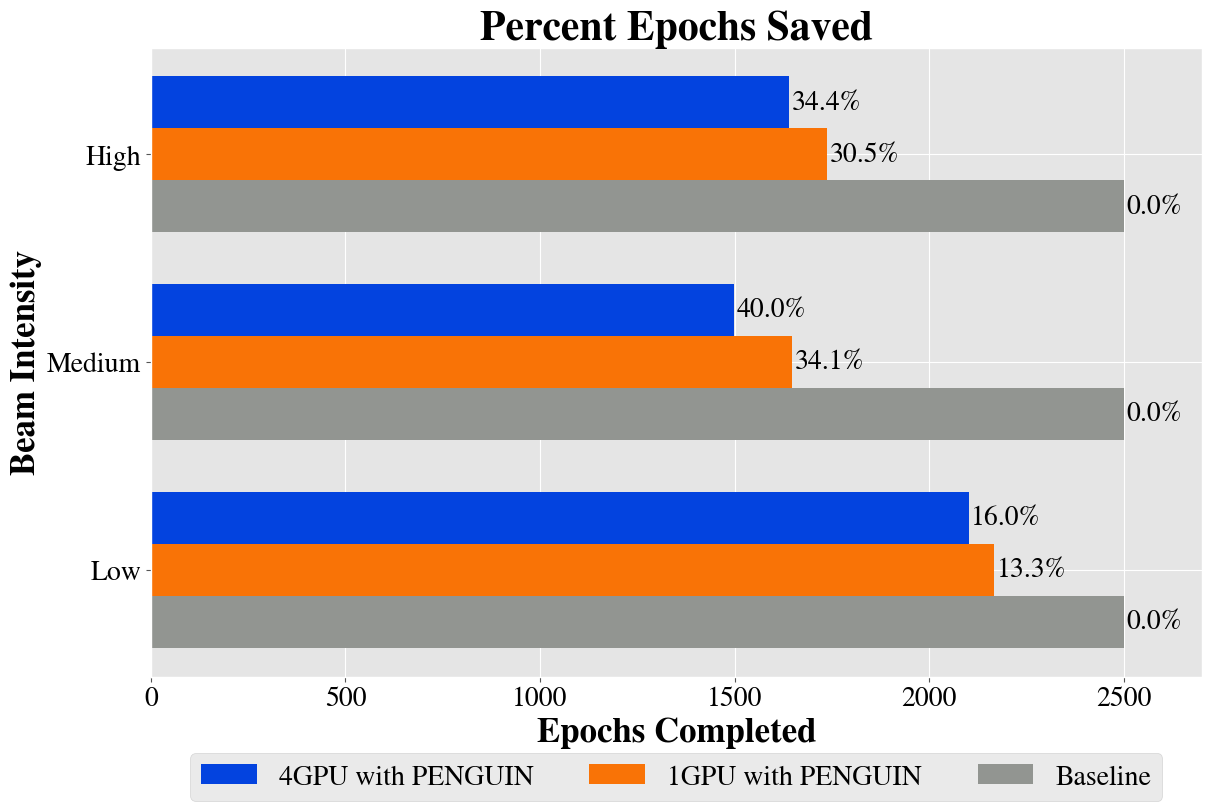

In [5]:
no_stop, stop = calculate_and_plot_epochs_savings(data_files)

## Time Savings

In [6]:
def print_wall_times(no_stop, stop):
    print("No PENGUIN:")
    for n, beam in enumerate(no_stop): # Non-stop DataFrames for 1e14, 1e15, 1e16
        for i, df in enumerate(beam):
            if i % 2 == 0: # 1 GPU
                try:
                    gpu1_time = df['epoch_times'].sum()/secs
                    print(f"1 GPU: {gpu1_time}")
                except:
                    print("Non stop 1 GPU: these runs don't have epoch times")
            else: # 4 GPU
                try:
                    gpu4_time = df['epoch_times'].sum()/secs
                    print(f"4 GPUS: {gpu4_time}")
                except:
                    print("Non stop 4 GPU: these runs don't have epoch times")
    print("\nWith PENGUIN:")
    for n, val in enumerate(stop): # Stopped DataFrames for 1e14, 1e15, 1e16
        for i, df in enumerate(val):
            if i % 2 == 0: # 1 GPU
                try:
                    gpu1_time = df['epoch_times'].sum()/secs
                    print(f"1 GPU: {gpu1_time}")
                except:
                    print("Stop 1 GPU: these runs don't have epoch times")
            else: # 4 GPU
                try:
                    gpu4_time = df['epoch_times'].sum()/secs
                    print(f"4 GPUS: {gpu4_time}")
                except:
                    print("Stop 4 GPU: these runs don't have epoch times")
    return

def get_run_time(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time

def get_run_seconds(row):
    days = int(row.split('-')[0])
    hours = int(row.split('-')[1].split('_')[0])
    minutes = int(row.split('-')[1].split('_')[1])
    seconds = int(row.split('-')[1].split('_')[2])
    time = timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)
    return time.total_seconds()

def plot_times():
    time_df = pd.read_csv('./icpp_training_results/time_to_run.csv')

    # DataFrame filtering conditions
    b14, b15, b16 = (time_df['dataset']==14), (time_df['dataset']==15), (time_df['dataset']==16)
    no_stop, stop = (time_df['stopping']==False), (time_df['stopping']==True)
    gpu1, gpu4 = (time_df['gpu']==1), (time_df['gpu']==4)
    time_format = 'total_seconds'

    # Filtering data
    no_stop_1e14 = np.array([time_df[b14 & no_stop & gpu1][time_format].item(), time_df[b14 & no_stop & gpu4][time_format].item()])/secs
    no_stop_1e15 = np.array([time_df[b15 & no_stop & gpu1][time_format].item(), time_df[b15 & no_stop & gpu4][time_format].item()])/secs
    no_stop_1e16 = np.array([time_df[b16 & no_stop & gpu1][time_format].item(), time_df[b16 & no_stop & gpu4][time_format].item()])/secs

    stop_1e14 = np.array([time_df[b14 & stop & gpu1][time_format].item(), time_df[b14 & stop & gpu4][time_format].item()])/secs
    stop_1e15 = np.array([time_df[b15 & stop & gpu1][time_format].item(), time_df[b15 & stop & gpu4][time_format].item()])/secs
    stop_1e16 = np.array([time_df[b16 & stop & gpu1][time_format].item(), time_df[b16 & stop & gpu4][time_format].item()])/secs

    epochs_run = {
        '1GPU': (no_stop_1e14[0], no_stop_1e15[0], no_stop_1e16[0]),
        '1GPU + PENGUIN': (stop_1e14[0], stop_1e15[0], stop_1e16[0]),
        '4GPU': (no_stop_1e14[1], no_stop_1e15[1], no_stop_1e16[1]),
        '4GPU + PENGUIN': (stop_1e14[1], stop_1e15[1], stop_1e16[1]),
    }

    x = np.arange(len(beams))  # the label locations
    width = 0.19  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    colors = ["xkcd:pale orange", "xkcd:orange", "xkcd:sky", "xkcd:blue"]

    print()
    for index, (label, times) in enumerate(epochs_run.items()):
        print(label, times)
        offset = width * multiplier
        rects = ax.bar(x + offset, times, width, label=label, color=colors[index]) 
        labels = [round(time, 2) for time in times]
        ax.bar_label(rects, labels=labels ,padding=2, font=tick_font)
        multiplier += 1

    # Labels, title, x-axis tick labels, etc.
    ax.set_ylabel('Run Time (hours)', font=lfont)
    ax.xaxis.label.set_color('black')
    ax.set_xlabel('Beam Intensity', font=lfont)
    ax.yaxis.label.set_color('black')

    ax.set_title('Wall Hours Spent', font=tfont)
    ax.set_xticks(x + width, beams)
    ax.set_xticklabels(beams, color='black', font=tick_font)
    ax.set_yticklabels(ax.get_yticks(), color='black', font=tick_font)

    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1),  ncol=4, prop=tick_font)
    display(fig)
    plt.savefig('figures/time_saved.png')
    plt.close()
    
    return

def save_and_plot_times():
    gpu=[1,1,1,1,1,1,4,4,4,4,4,4]
    stopping=[False, False, False, True, True, True, False, False, False, True, True, True]
    dataset=['14','15','16','14','15','16','14','15','16','14','15','16']
    time=['2-02_01_42','2-03_52_23','2-00_38_20','1-22_33_04','1-12_05_38','1-08_18_16','0-14_32_18','0-14_54_32','0-13_53_12','0-12_03_46','0-09_10_05','0-09_27_38']

    time_df = pd.DataFrame()
    time_df['gpu'] = gpu
    time_df['dataset'] = dataset
    time_df['stopping'] = stopping
    time_df['time'] = time
    time_df['total_time'] = time_df['time'].apply(get_run_time)
    time_df['total_seconds'] = time_df['time'].apply(get_run_seconds)

    time_df.to_csv('./icpp_training_results/time_to_run.csv', index=False)
    plot_times()
    return 

### Observe the Total GPU Wall Times

In [7]:
print_wall_times(no_stop, stop)

No PENGUIN:
Non stop 1 GPU: these runs don't have epoch times
Non stop 4 GPU: these runs don't have epoch times
Non stop 1 GPU: these runs don't have epoch times
Non stop 4 GPU: these runs don't have epoch times
Non stop 1 GPU: these runs don't have epoch times
Non stop 4 GPU: these runs don't have epoch times

With PENGUIN:
1 GPU: 46.350929785768194
4 GPUS: 40.50905620786879
1 GPU: 35.91131767789523
Stop 4 GPU: these runs don't have epoch times
1 GPU: 32.134367143445544
4 GPUS: 31.63662725733386


### Now plot all wall hours of each run


1GPU (50.028333333333336, 51.87305555555555, 48.638888888888886)
1GPU + PENGUIN (46.55111111111111, 36.09388888888889, 32.30444444444444)
4GPU (14.538333333333334, 14.908888888888889, 13.886666666666667)
4GPU + PENGUIN (12.062777777777777, 9.168055555555556, 9.460555555555555)


/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/3857435258.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color='black', font=tick_font)


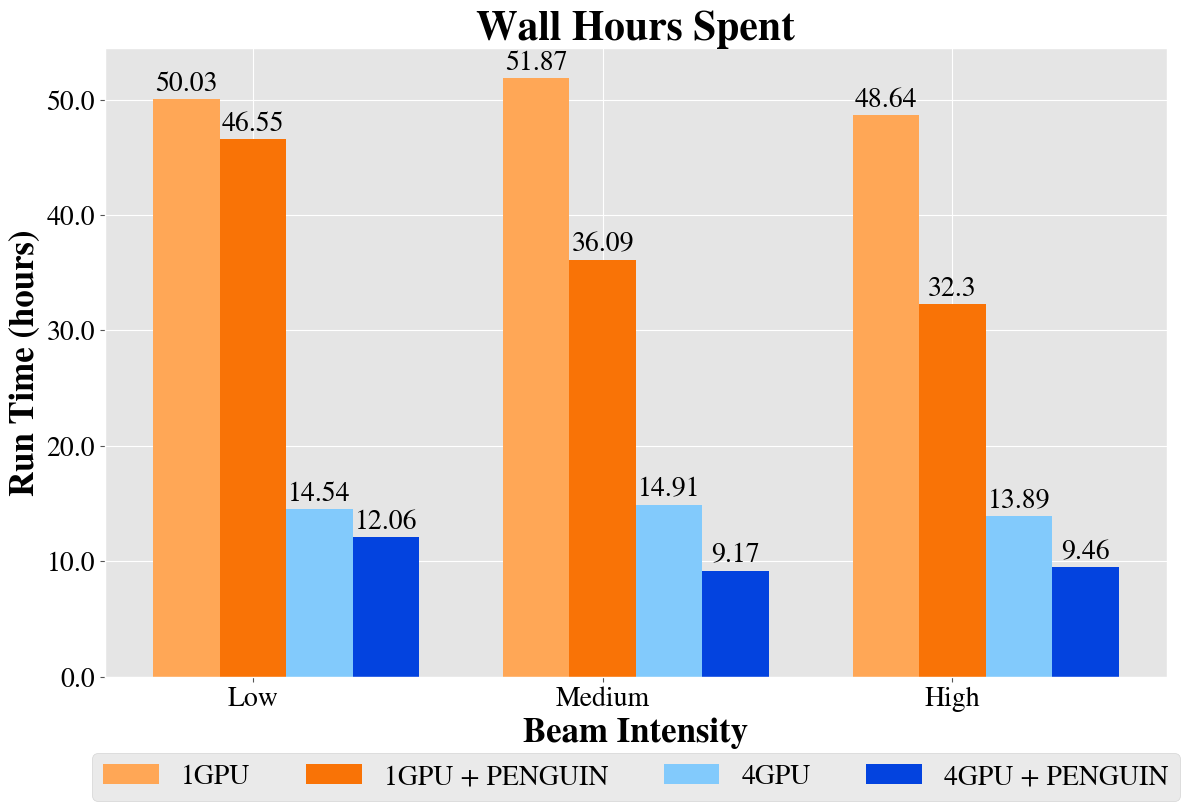

In [8]:
save_and_plot_times()

## Classification Results and Pareto Optimality

In [9]:
def one_line_per_arch_penguin(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    if sorted_by_epoch['converged'].iloc[0] == True:
        to_return = sorted_by_epoch['predictions'].iloc[0]
        # print(to_return)
    else:
        to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def one_line_per_arch(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch', ascending=False)
    to_return = sorted_by_epoch['val_accs'].iloc[0]
    return pd.Series({'final_acc':to_return, 'flops':arch_df['flops'].iloc[0], 'converged':sorted_by_epoch['converged'].iloc[0]})

def is_pareto_efficient_simple(unadjusted_costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """

    # this assumes minimization, so we need to invert accuracy to make bigger, better
    # we should look more closely at this
    costs = np.zeros(unadjusted_costs.shape, dtype=float)
    costs[:,1] = unadjusted_costs[:,1]
    costs[:,0] = unadjusted_costs[:,0] * -1
    
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def make_graphic(one_line, pareto_optimals, title="FLOPS vs. Val Accuracy per Architecture", gens=10, children=10):
    fig, ax = plt.subplots(layout='constrained', figsize=figsize, dpi=160)

    as_numpy = one_line.to_numpy()

    plt.xlabel('FLOPS', color='black', font=lfont)
    plt.ylabel('Validation Accuracy', color='black', font=lfont)
    plt.title(title, font=tfont)
    plt.ylim(85, 100.2)

    colors = cm.viridis_r(np.linspace(0, 1, gens))
    size=100

    labels = list()
    start, end, ng = 0, 0, 0
    for g in range(0, gens * children):
        if g == 0 or g % gens == 0:
            start = g
            end = start + (children - 1)
            labels.append(f"Generation {g // gens}")
        
            ngen = as_numpy[start:end + 1]
            ax.scatter(as_numpy[start:end+1, 2], as_numpy[start:end+1, 1], color=colors[g // gens], s=size, label=f"Generation {g // gens}", zorder=3)
    
    accs = pareto_optimals['final_acc'].to_numpy()
    flops = pareto_optimals['flops'].to_numpy()
    labels.append('Pareto Optimal')
    ax.scatter(flops, accs, s=250, marker='o', color='xkcd:red', facecolor='None', linewidths=1.2, label='Pareto Optimal', zorder=10)
    ax.set_xticklabels(ax.get_xticks(), color="black", font=tick_font)
    ax.set_yticklabels(ax.get_yticks(), color="black", font=tick_font)
    plt.legend(labels, loc='lower right', prop=tick_font)

    display(fig)
    plt.savefig('figures/'+title.replace(" ", "_")+'.png')
    plt.close()
    return 


def plot_paretos(no_stop, stop):

    for n, beam in enumerate(no_stop): # Non-stop DataFrames for 1e14, 1e15, 1e16
        if n == 0: # 1e14
            tb = "Low Beam"
        elif n == 1: # 1e15
            tb = "Medium Beam"
        elif n == 2: # 1e16
            tb = "High Beam"
            
        for i, df in enumerate(beam):
            if i % 2 == 0: # 1 GPU
                title = f'1GPU with {tb} without PENGUIN'
            else:
                title = f'4GPU with {tb} without PENGUIN'

            by_arch = df.groupby('arch')
            one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
            sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
            costs = one_line[['final_acc', 'flops']].to_numpy()
            pareto_optimals = is_pareto_efficient_simple(costs)
            one_line['pareto_optimal'] = pareto_optimals
            pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
            print(f"\nParetos For {tb}:\n {pareto_optimal_arches}")
            make_graphic(one_line, pareto_optimal_arches, title=title)

    for n, beam in enumerate(stop): # Non-stop DataFrames for 1e14, 1e15, 1e16
        if n == 0: # 1e14
            tb = "Low Beam"
        elif n == 1: # 1e15
            tb = "Medium Beam"
        elif n == 2: # 1e16
            tb = "High Beam"
            
        for i, df in enumerate(beam):
            if i % 2 == 0: # 1 GPU
                title = f'1GPU with {tb} with PENGUIN'
            else:
                title = f'4GPU with {tb} with PENGUIN'

            by_arch = df.groupby('arch')
            one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()
            sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
            costs = one_line[['final_acc', 'flops']].to_numpy()
            pareto_optimals = is_pareto_efficient_simple(costs)
            one_line['pareto_optimal'] = pareto_optimals
            pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True]
            print(f"\nParetos For {tb}:\n {pareto_optimal_arches}")
            make_graphic(one_line, pareto_optimal_arches, title=title)   
    
    return

In [10]:
# plot_paretos(no_stop, stop)

## Code for PENGUiN times and variance

print("total penguin time 1gpu 1e14:", gpu1_1e14_stopping.penguin_times.sum())
print("total penguin time 1gpu 1e15:", gpu1_1e15_stopping.penguin_times.sum())
print("total penguin time 1gpu 1e16:", gpu1_1e16_stopping.penguin_times.sum())


print("total penguin time 4gpu 1e14:", gpu4_1e14_stopping.penguin_times.sum())
#print("total penguin time 4gpu 1e15:", gpu4_1e14_stopping)
print("total penguin time 4gpu 1e16:", gpu4_1e16_stopping.penguin_times.sum())

all_penguin_times = [gpu1_1e14_stopping.penguin_times.sum(),  gpu1_1e15_stopping.penguin_times.sum(),  gpu1_1e16_stopping.penguin_times.sum(), \
     gpu4_1e14_stopping.penguin_times.sum(),  gpu4_1e16_stopping.penguin_times.sum()]

total_num_epochs_across_these_runs = len(gpu1_1e14_stopping.index) + len(gpu1_1e15_stopping.index) + \
     len(gpu1_1e16_stopping.index) + len(gpu4_1e14_stopping.index) + len(gpu4_1e16_stopping.index) 

all_individual_penguin_times = np.array(gpu1_1e14_stopping.penguin_times.to_list()+  gpu1_1e15_stopping.penguin_times.to_list() + gpu1_1e16_stopping.penguin_times.to_list() \
     + gpu4_1e14_stopping.penguin_times.to_list() +  gpu4_1e16_stopping.penguin_times.to_list())


avg_over_run = sum(all_penguin_times)/len(all_penguin_times)
avg_per_epoch = sum(all_penguin_times)/total_num_epochs_across_these_runs
res = np.var(all_individual_penguin_times)

print("Average time spent on PENGUIN over entire run:", avg_over_run)
print("Average time spent on PENGUIN per epoch:", avg_per_epoch)
print("Variance of PENGUIN length in epoch:", res)


## Figure 2: Predicted Model Accuracy vs. Observed Accuracy

In [11]:
def get_epoch_converged(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch')
    try:
        converged = sorted_by_epoch[sorted_by_epoch.converged==True].iloc[0]
        return pd.Series({'epoch_converged': converged['epoch'], 'final_fitness': sorted_by_epoch['val_accs'].iloc[-1], 'prediction':converged['predictions']})
    except:
        return pd.Series({'epoch_converged': np.inf, 'final_fitness': sorted_by_epoch['val_accs'].iloc[-1], 'prediction':None})

df= pd.read_csv('icpp_training_results/1gpu/no_stopping/1gpu_1e15_training_data.csv')
by_arch = df.groupby('arch')
where_converged = by_arch.apply(get_epoch_converged).reset_index()  
print(where_converged.sort_values('epoch_converged', ascending=True).iloc[20:40])

    arch  epoch_converged  final_fitness  prediction
9      9              9.0      99.987402   97.726776
33    33              9.0      99.981104   96.749503
82    82              9.0      98.904006   89.177712
98    98              9.0      97.442681   89.334014
61    61              9.0      99.483497   94.791125
55    55             10.0      99.930713   97.606809
58    58             10.0      97.952885   92.716285
6      6             10.0      99.911817   99.324454
37    37             10.0      99.533888   95.852044
38    38             11.0      99.943311   99.614529
7      7             11.0      97.864701   93.434028
83    83             11.0      99.943311   98.963262
64    64             11.0      98.929201   88.219842
54    54             11.0      99.111867   92.787099
91    91             11.0      99.905518   98.770422
51    51             11.0      98.563870   93.837877
88    88             11.0      98.664651   91.570552
2      2             11.0      99.918115   98.

In [12]:
percent_converged = len(where_converged[where_converged.epoch_converged!=np.inf].index) / len(where_converged.index) * 100
print("Percent Converged is: ", percent_converged)

mean = where_converged[where_converged.epoch_converged!=np.inf].epoch_converged.mean()
print("Avg epoch converged (for those converged) is: ", mean)

print("converged arches and their earliest convergence:")
only_converged_arches = pd.DataFrame(where_converged.loc[where_converged.epoch_converged!=np.inf,:])
only_converged_arches.head()

Percent Converged is:  73.0
Avg epoch converged (for those converged) is:  11.945205479452055
converged arches and their earliest convergence:


,arch,epoch_converged,final_fitness,prediction
0,0,24.0,99.281935,99.788292
1,1,16.0,99.559083,94.197689
2,2,11.0,99.918115,98.678220
6,6,10.0,99.911817,99.324454
7,7,11.0,97.864701,93.434028


/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/2754558643.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/2754558643.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)


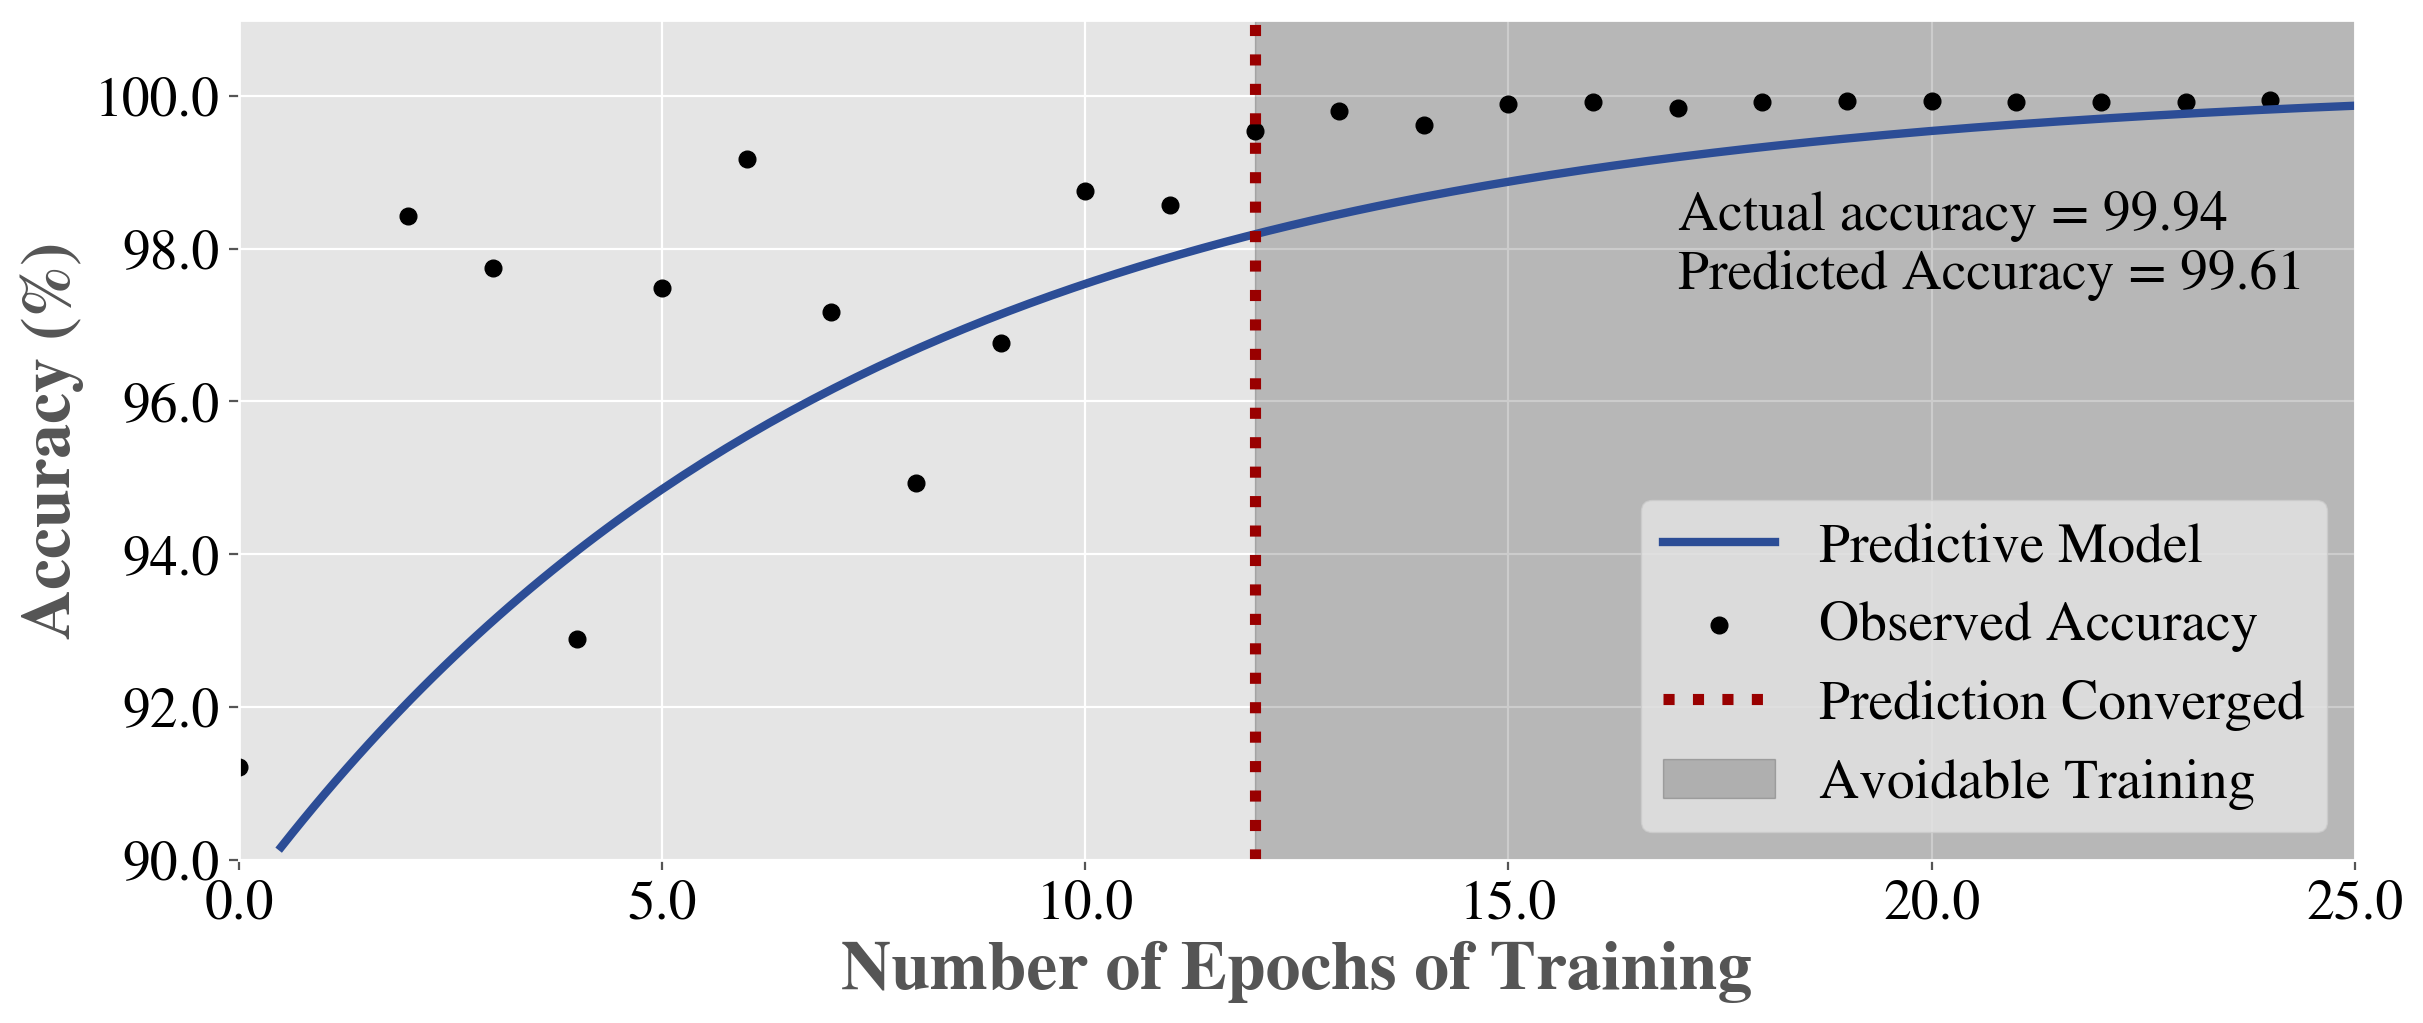

In [13]:
arch_44 = df[df['arch']==38]
fig, ax = plt.subplots(layout='constrained', figsize=(12,5), dpi=200)

a, b, c = 100.2, 1.15, 17

x = np.linspace(0.5,26,200)
y = a-b**(c-x)

epochs, fitness = arch_44['epoch'].to_list(), arch_44['val_accs'].to_list()
prediction, actual = 99.614529, 99.943311

ax.plot(x,y,color="#2C4D96",label="Predictive Model", linewidth=3)

ax.scatter(epochs, fitness, c='black', marker='o', facecolor='None', label='Observed Accuracy')
ax.vlines(12,90,101,colors='#990000',linestyles=":",linewidth=4, label="Prediction Converged")
ax.axvspan(12, 26, color = 'k', alpha = 0.2, label="Avoidable Training")

ax.annotate('Predicted Accuracy = {:.2f}'.format(prediction), xy=(0.68, 0.68), xycoords='axes fraction', font=tick_font)
ax.annotate('Actual accuracy = {:.2f}'.format(actual), xy=(0.68, 0.75), xycoords='axes fraction', font=tick_font)

ax.set_ylim(90, 101)
ax.set_xlim(0, 25)

ax.set_ylabel("Accuracy (%)", font=lfont)
ax.set_xlabel("Number of Epochs of Training", font=lfont)

ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
ax.legend(loc='lower right', prop=tick_font)

plt.savefig('figures/penguin_example.png')

# Figure 8 - Single GPU Top 3 Pareto Optimal Architectures

/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/3231400420.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/3231400420.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/3231400420.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/3231400420.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)


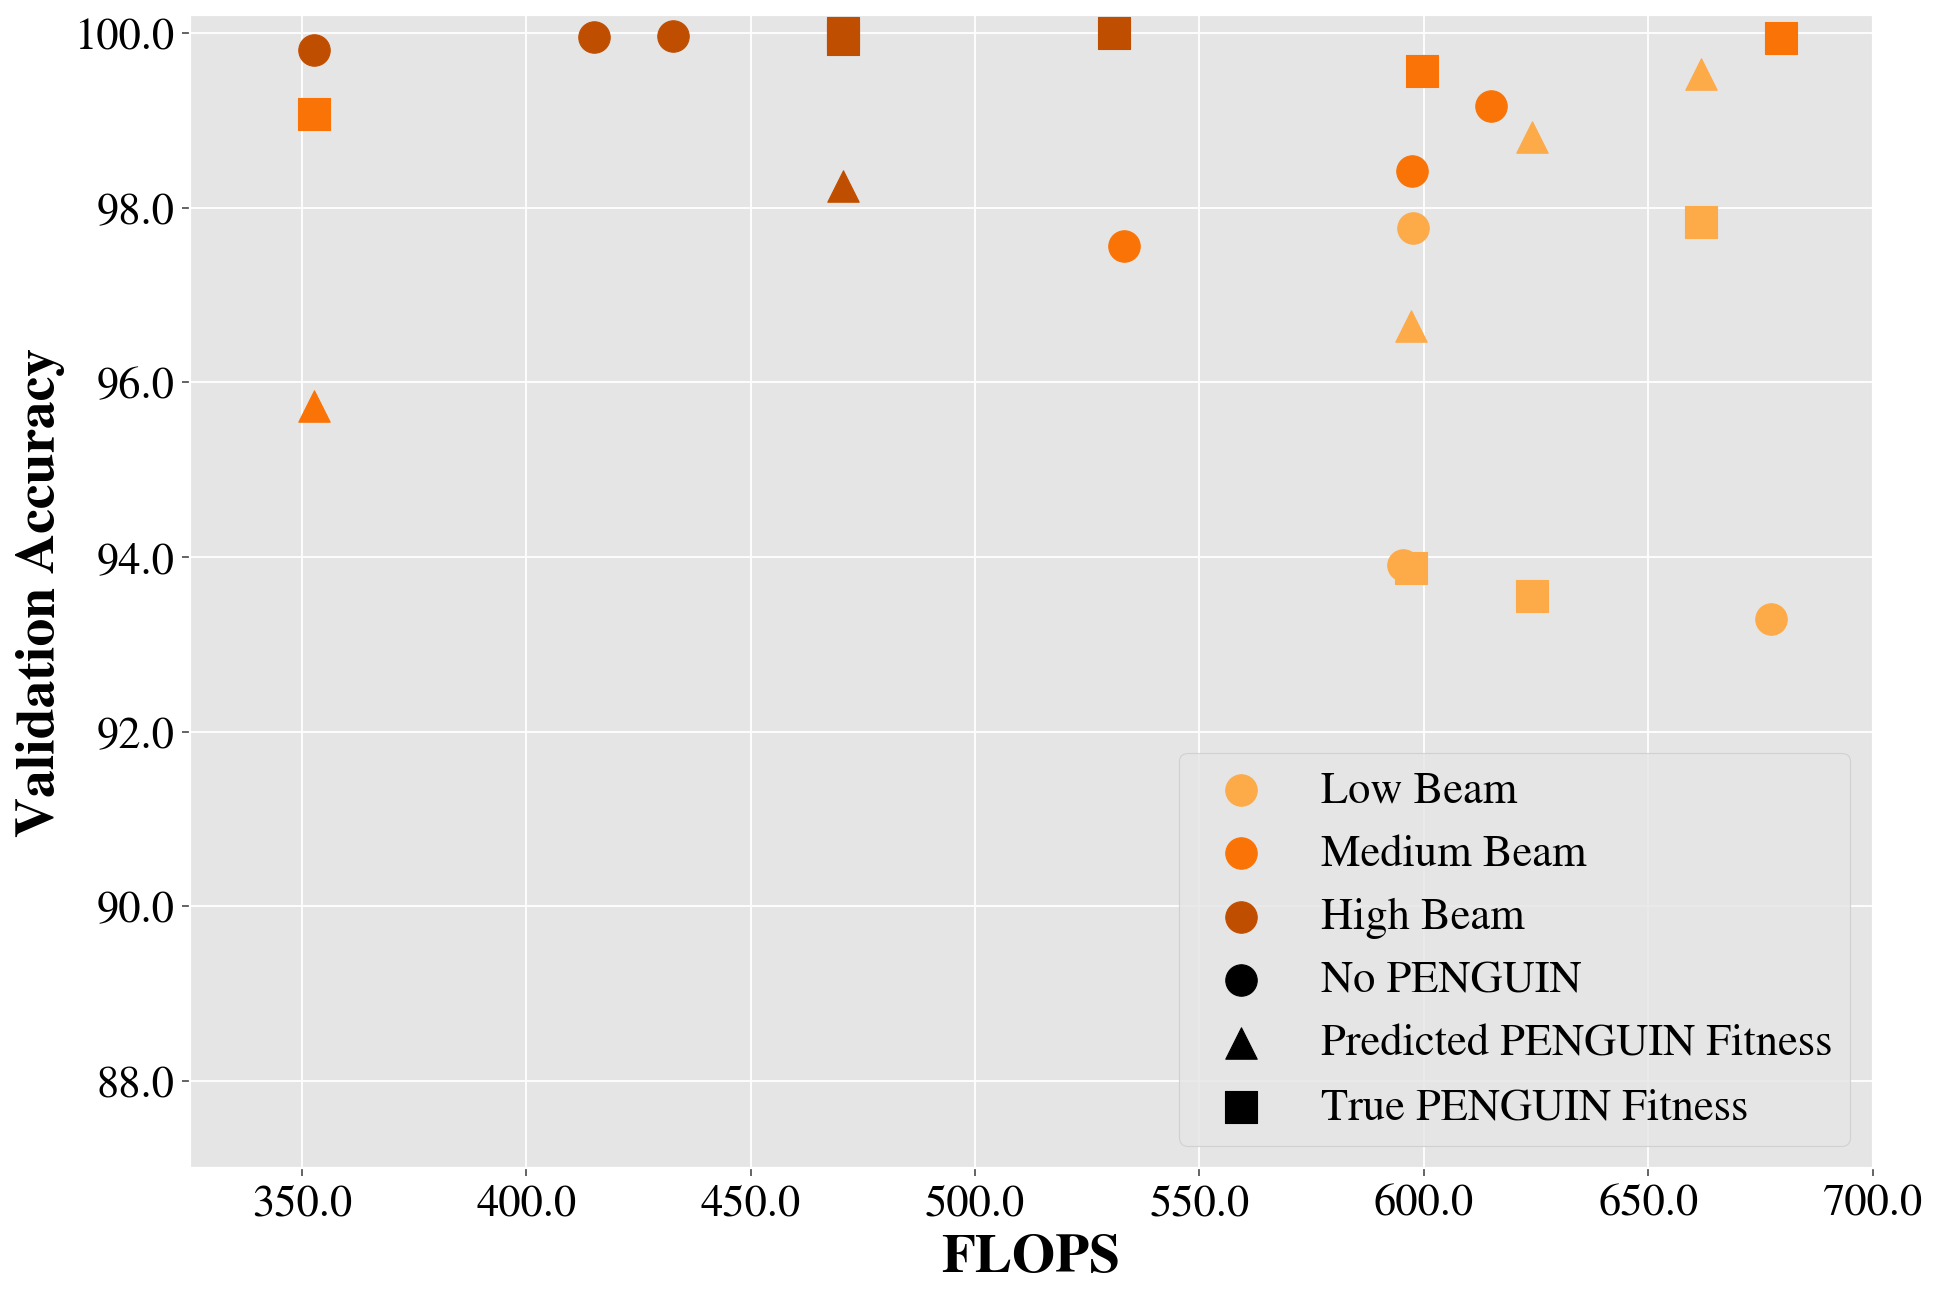

In [14]:
# 1 GPU - Table 2
fig, ax = plt.subplots(layout='constrained', figsize=figsize, dpi=160)

plt.xlabel('FLOPS', color='black', font=lfont)
plt.ylabel('Validation Accuracy', color='black', font=lfont)
plt.xlim(325, 700)
plt.ylim(87, 100.2)

colors = ["xkcd:light orange", "xkcd:orange", "xkcd:burnt orange"]
markers = ["o", "^", ""]
size=200

low_no = [93.909045, 93.293021, 97.763920]
low_no_peng_flops = [595.47, 677.27, 597.57]
low_pred = [98.804643, 96.645275, 99.532435]
low_true = [93.55, 93.87, 97.833207]
low_peng_flops = [624.04, 597.04, 661.70]

medium_no = [99.162257, 97.564701, 98.412698]
medium_no_peng_flops = [615.04, 533.20, 597.33]
medium_pred = [99.559083, 95.722359, 99.937012]
medium_true = [99.559083, 99.067775, 99.937012]
medium_peng_flops = [599.71, 352.82, 679.70]

high_no = [99.798438, 99.968506, 99.949609]
high_no_peng_flops = [352.82, 432.79, 415.08]
high_pred = [99.930713, 98.251432, 100.000000]
high_true = [99.930713, 100.000000, 100.000000]
high_peng_flops = [470.66, 470.66, 531.06]

l1 = ax.scatter(low_no_peng_flops, low_no, marker= "o" , s=size, color=colors[0], label= "Low Beam" )
l2 = ax.scatter(low_peng_flops, low_pred,  s=size, marker= "^" , color=colors[0])
l3 = ax.scatter(low_peng_flops, low_true, s=size, marker="s", color=colors[0])

l4 = ax.scatter(medium_no_peng_flops, medium_no, marker= "o" , s=size, color=colors[1], label= "Medium Beam" )
l5 = ax.scatter(medium_peng_flops, medium_pred, s=size, marker= "^" , color=colors[1])
l6 = ax.scatter(medium_peng_flops, medium_true, s=size, marker="s", color=colors[1])

l7 = ax.scatter(high_no_peng_flops, high_no, s=size, marker= "o" , color=colors[2], label= "High Beam" )
l8 = ax.scatter(high_peng_flops, high_pred, s=size, marker= "^" , color=colors[2])
l9 = ax.scatter(high_peng_flops, high_true, s=size, marker="s", color=colors[2])

l10 = ax.scatter([0], [0], s=size, marker='o', color= "black" , label= "No PENGUIN" )
l11 = ax.scatter([0], [0], s=size, marker='^', color= "black" , label= "Predicted PENGUIN Fitness" )
l12 = ax.scatter([0], [0], s=size, marker='s', color= "black", label = "True PENGUIN Fitness")

ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
ax.legend(handles=[l1, l4, l7, l10, l11, l12], loc= "lower right" , prop=tick_font)

ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
plt.savefig('figures/table2.png')

# Figure 9 - 4 GPUs Top 3 Pareto Optimal Architectures

/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/717272856.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/717272856.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/717272856.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/717272856.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)


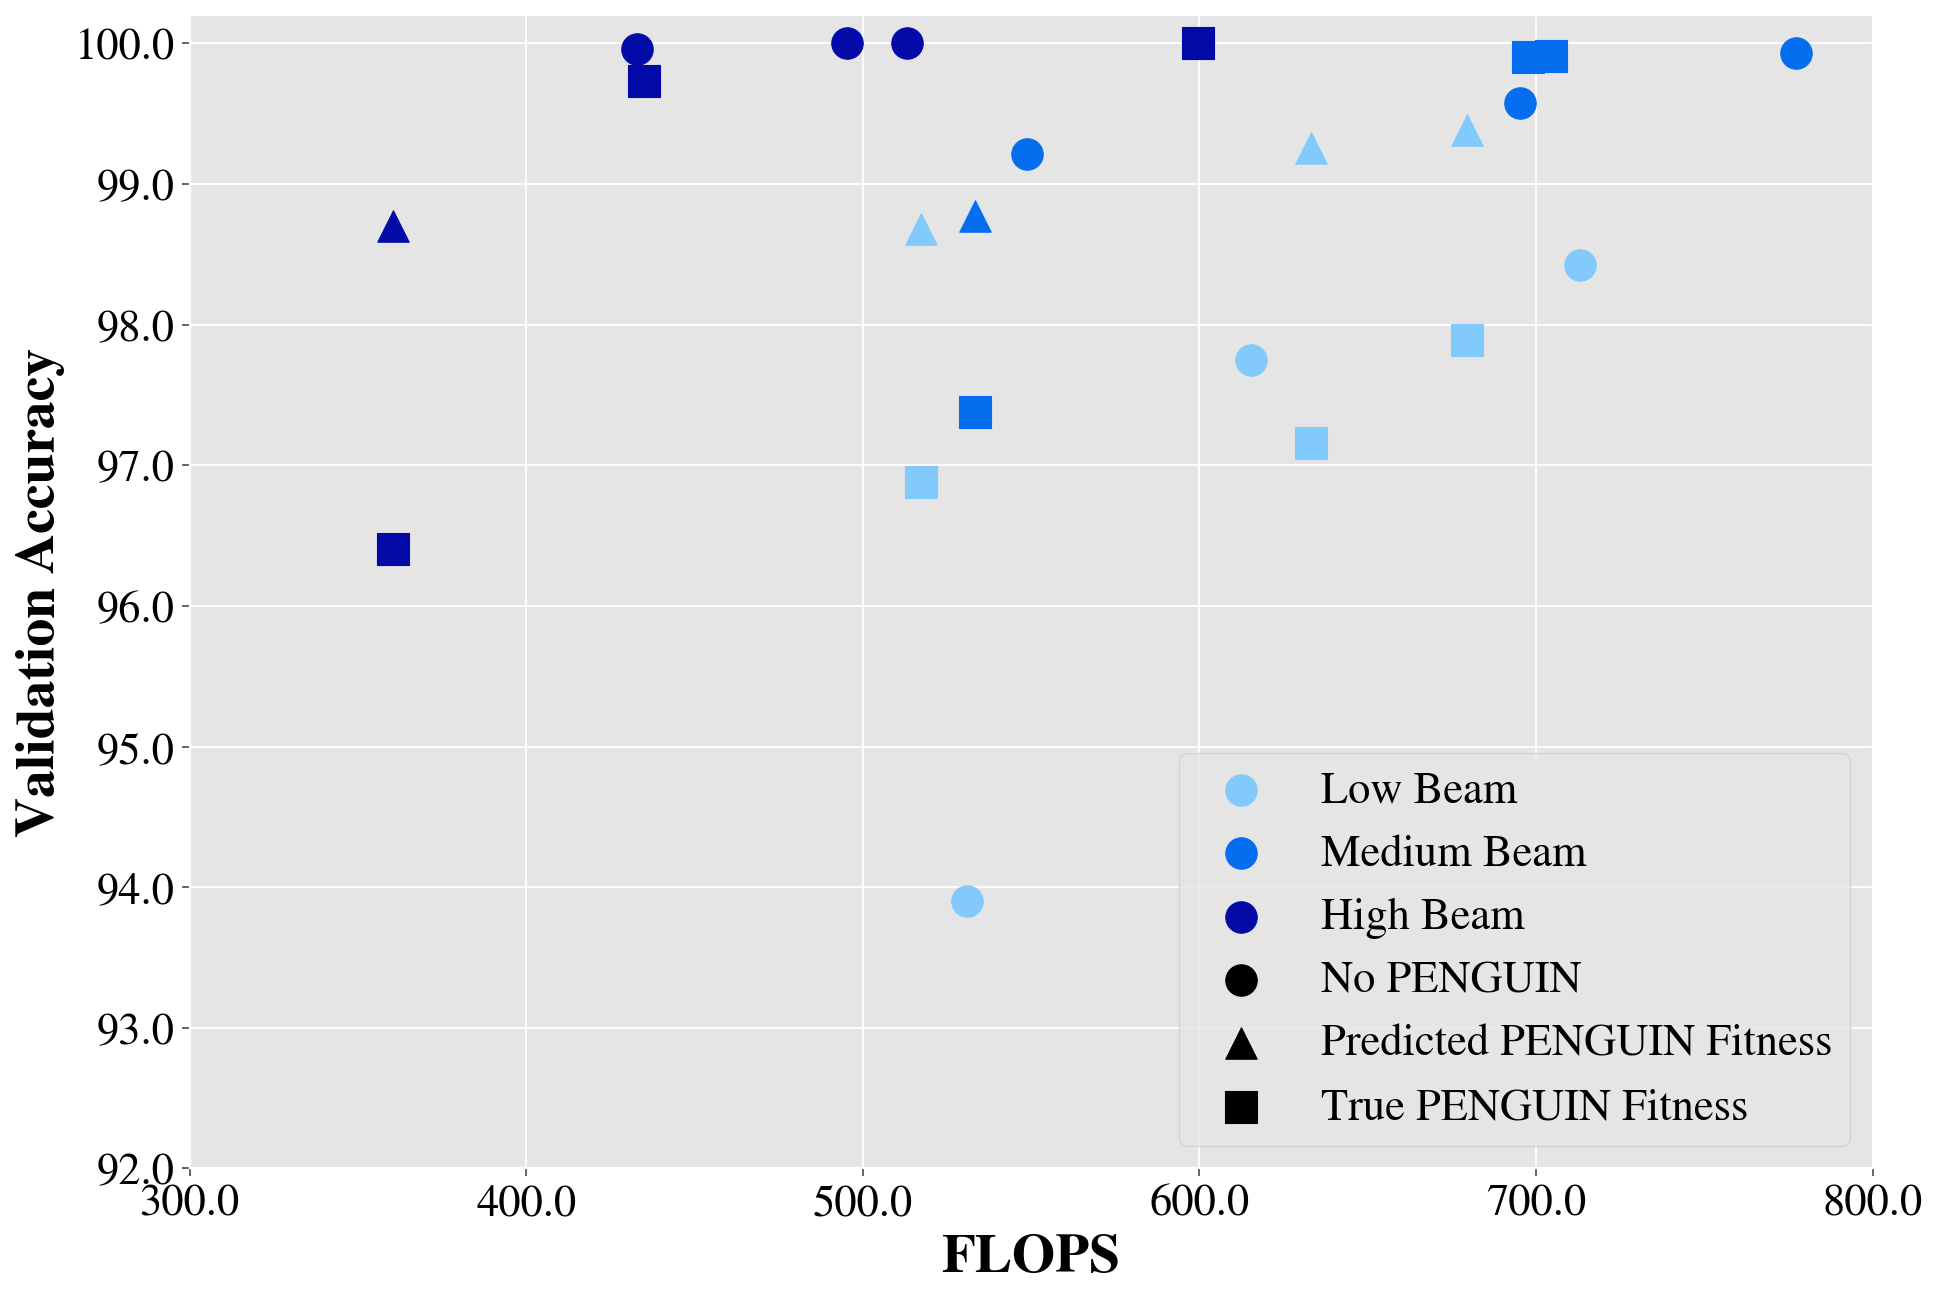

In [15]:
# 4 GPU - Table 3
fig, ax = plt.subplots(layout='constrained', figsize=figsize, dpi=160)

plt.xlabel('FLOPS', color='black', font=lfont)
plt.ylabel('Validation Accuracy', color='black', font=lfont)
plt.xlim(300, 800)
plt.ylim(92, 100.2)

colors = ["xkcd:sky", "xkcd:cerulean blue", "xkcd:cobalt blue"]
markers = ["o", "^", ""]
size=200

low_no = [97.751323, 98.425296, 93.902746]
low_no_peng_flops = [615.2853, 712.9844, 531.0555]
low_pred = [98.680175, 99.259251, 99.383542 ]
low_true = [96.882086 , 97.159234, 97.889897 ]
low_peng_flops = [517.2993, 633.2752, 679.4103]

medium_no = [99.212648, 99.577979, 99.930713 ]
medium_no_peng_flops = [548.7686 , 695.3055 , 777.1094 ]
medium_pred = [98.770630, 99.911817, 99.905518]
medium_true = [97.379693, 99.911817, 99.905518]
medium_peng_flops = [533.2046, 704.4046, 697.6971]

high_no = [100.000000, 100.000000, 99.962207 ]
high_no_peng_flops = [513.0555 , 495.3423, 432.7927]
high_pred = [100.000000, 98.704736, 99.735450]
high_true = [100.000000, 96.403376 , 99.735450]
high_peng_flops = [599.7112, 360.3750, 434.9419]

l1 = ax.scatter(low_no_peng_flops, low_no, marker= "o" , s=size, color=colors[0], label= "Low Beam" )
l2 = ax.scatter(low_peng_flops, low_pred,  s=size, marker= "^" , color=colors[0])
l3 = ax.scatter(low_peng_flops, low_true, s=size, marker="s", color=colors[0])

l4 = ax.scatter(medium_no_peng_flops, medium_no, marker= "o" , s=size, color=colors[1], label= "Medium Beam" )
l5 = ax.scatter(medium_peng_flops, medium_pred, s=size, marker= "^" , color=colors[1])
l6 = ax.scatter(medium_peng_flops, medium_true, s=size, marker="s", color=colors[1])

l7 = ax.scatter(high_no_peng_flops, high_no, s=size, marker= "o" , color=colors[2], label= "High Beam" )
l8 = ax.scatter(high_peng_flops, high_pred, s=size, marker= "^" , color=colors[2])
l9 = ax.scatter(high_peng_flops, high_true, s=size, marker="s", color=colors[2])

l10 = ax.scatter([0], [0], s=size, marker='o', color= "black" , label= "No PENGUIN" )
l11 = ax.scatter([0], [0], s=size, marker='^', color= "black" , label= "Predicted PENGUIN Fitness" )
l12 = ax.scatter([0], [0], s=size, marker='s', color= "black", label = "True PENGUIN Fitness")

ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
ax.legend(handles=[l1, l4, l7, l10, l11, l12], loc= "lower right" , prop=tick_font)

ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
plt.savefig('figures/table3.png')

In [16]:
gpu1_1e14_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e14_stopping_training_data.csv')
gpu1_1e15_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e15_stopping_training_data.csv')
gpu1_1e16_stopping = pd.read_csv('./icpp_training_results/1gpu/stopping/1gpu_1e16_stopping_training_data.csv')
gpu4_1e14_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e14_stopping_training_data.csv')
gpu4_1e15_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e15_stopping_training_data.csv')
gpu4_1e16_stopping = pd.read_csv('./icpp_training_results/4gpu/stopping/4gpu_1e16_stopping_training_data.csv')

all_stopping = [gpu1_1e14_stopping, gpu1_1e15_stopping, gpu1_1e16_stopping, gpu4_1e14_stopping, gpu4_1e15_stopping, gpu4_1e16_stopping]

In [23]:
def get_epoch_converged(arch_df):
    sorted_by_epoch = arch_df.sort_values('epoch')
    try:
        converged = sorted_by_epoch[sorted_by_epoch.converged==True].iloc[0]
        return pd.Series({'epoch_converged': converged['epoch'], 'final_fitness': sorted_by_epoch['val_accs'].iloc[-1], 'prediction':converged['predictions']})
    except:
        return pd.Series({'epoch_converged': np.inf, 'final_fitness': sorted_by_epoch['val_accs'].iloc[-1], 'prediction':None})

df = gpu1_1e15_stopping
df.head()
by_arch = df.groupby('arch')
where_converged = by_arch.apply(get_epoch_converged).reset_index()  

In [24]:
percent_converged = len(where_converged[where_converged.epoch_converged!=np.inf].index) / len(where_converged.index) * 100
print("Percent Converged is: ", percent_converged)

mean = where_converged[where_converged.epoch_converged!=np.inf].epoch_converged.mean()
print("Avg epoch converged (for those converged) is: ", mean)

print("converged arches and their earliest convergence:")
only_converged_arches = pd.DataFrame(where_converged.loc[where_converged.epoch_converged!=np.inf,:])
only_converged_arches.head()

Percent Converged is:  69.0
Avg epoch converged (for those converged) is:  11.63768115942029
converged arches and their earliest convergence:


,arch,epoch_converged,final_fitness,prediction
0,0,5.0,93.020912,92.622012
2,2,8.0,98.412698,97.846239
3,3,8.0,97.549761,96.689185
5,5,8.0,98.305619,98.925455
7,7,13.0,95.956160,95.899747


## Figure 11 - Violin Plot of Convergence

percent converged is: 61.0
percent converged is: 69.0
percent converged is: 56.00000000000001
percent converged is: 67.0
percent converged is: 80.0
percent converged is: 57.99999999999999


/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/1188038152.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Low Beam\n1 GPU', 'Medium Beam\n1 GPU', 'High Beam\n1 GPU', 'Low Beam\n4 GPU', 'Medium Beam\n4 GPU', 'High Beam\n4 GPU'], font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/1188038152.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), font=tick_font)


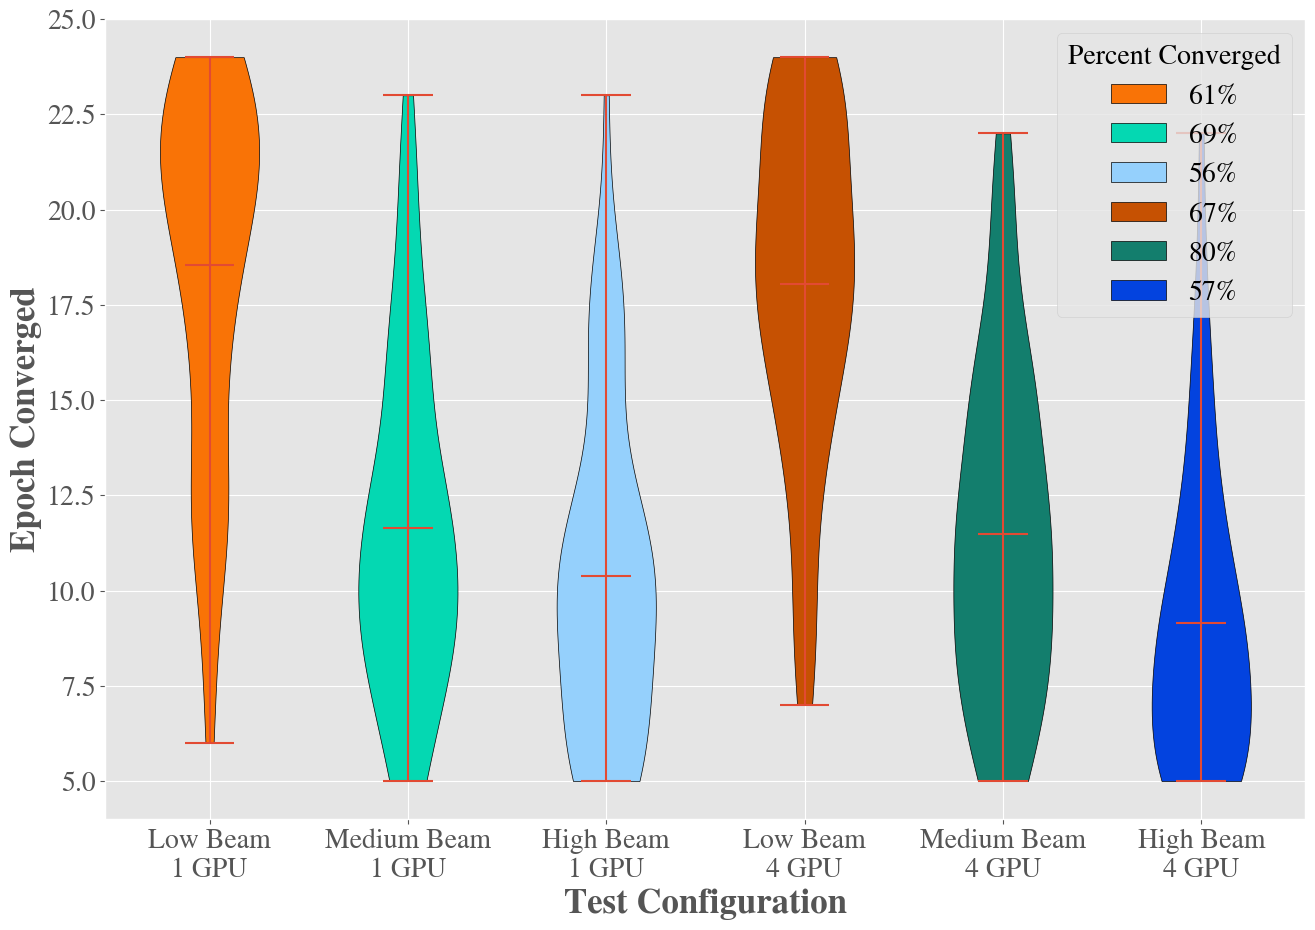

In [19]:
sets = list()
percents = list()

for df in all_stopping:
    by_arch = df.groupby('arch')
    where_converged = by_arch.apply(get_epoch_converged).reset_index()
    only_converged_arches = pd.DataFrame(where_converged.loc[where_converged.epoch_converged!=np.inf,:])
    sets.append(only_converged_arches.epoch_converged.to_list())
    

    percent_converged = len(where_converged[where_converged.epoch_converged!=np.inf].index) / len(where_converged.index) * 100
    percents.append(percent_converged)
    print("percent converged is:", percent_converged)

data_to_plot = sets
fig, ax = plt.subplots(layout='constrained', figsize=figsize)

ax = fig.add_axes([0,0,1,1])

ax.set_ylim(4, 25)
ax.set_xticklabels(['', 'Low Beam\n1 GPU', 'Medium Beam\n1 GPU', 'High Beam\n1 GPU', 'Low Beam\n4 GPU', 'Medium Beam\n4 GPU', 'High Beam\n4 GPU'], font=tick_font)
ax.set_yticklabels(ax.get_yticks(), font=tick_font)
ax.set_xlabel('Test Configuration', font=lfont)
ax.set_ylabel('Epoch Converged', font=lfont)

bp = ax.violinplot(data_to_plot, showmeans=True)
colors=["xkcd:orange", "xkcd:aquamarine", "xkcd:light blue", "xkcd:dark orange", "xkcd:blue green", "xkcd:blue"]

for pc, color, percent in zip(bp['bodies'], colors, percents):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_label(str(int(percent))+'%')
    pc.set_alpha(1)

plt.legend(title="Percent Converged", prop=tick_font, title_fontproperties=tick_font)
plt.savefig('figures/violin_converged.png')
plt.show()


# Supplemental Figures

### 1. Single GPU Pareto Optimal Architectures 

In [20]:
all_paretos = pd.DataFrame()
for i in data_files:  
    df = pd.read_csv(i)
    by_arch = df.groupby('arch')

    if "1e14" in i:
        beam = "Low"
    elif "1e15" in i:
        beam = "Medium"
    elif "1e16" in i:  
        beam = "High"    

    if "no" in i:  
        stop = False
        one_line = by_arch.apply(one_line_per_arch).sort_values('arch', ascending=True).reset_index()  
    elif "stopping" in i:  
        stop = True  
        one_line = by_arch.apply(one_line_per_arch_penguin).sort_values('arch', ascending=True).reset_index()

    if "1gpu" in i:  
        gpu = 1  
    elif "4gpu" in i:  
        gpu = 4  

    print(one_line.head)
    sorted_by_fitness = one_line.sort_values('final_acc', ascending=False).head()
    costs = one_line[['final_acc', 'flops']].to_numpy()
    pareto_optimals = is_pareto_efficient_simple(costs) 
    one_line['pareto_optimal'] = pareto_optimals
    pareto_optimal_arches = one_line.loc[one_line['pareto_optimal'] == True].copy()

    pareto_optimal_arches['beam'] = beam
    pareto_optimal_arches['gpus'] = gpu
    pareto_optimal_arches['stop'] = stop

    all_paretos = pd.concat([all_paretos, pareto_optimal_arches], ignore_index=True)

df = all_paretos.copy()

<bound method NDFrame.head of     arch  final_acc     flops  converged
0      0  94.053918  740.0186       True
1      1  95.616024  893.3620      False
2      2  97.996977  993.3537       True
3      3  94.375157  731.0186       True
4      4  98.015873  917.7927      False
..   ...        ...       ...        ...
95    95  97.707231  695.5480       True
96    96  98.293021  712.9844      False
97    97  98.293021  677.2712      False
98    98  97.763920  597.5721       True
99    99  92.233560  450.7927       True

[100 rows x 4 columns]>
<bound method NDFrame.head of     arch  final_acc     flops  converged
0      0  99.281935  740.0186       True
1      1  99.559083  893.3620       True
2      2  99.918115  993.3537       True
3      3  99.685059  731.0186      False
4      4  99.905518  917.7927      False
..   ...        ...       ...        ...
95    95  99.074074  740.0186      False
96    96  98.412698  597.3296       True
97    97  99.981104  904.2344       True
98    98  97.

/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/638349021.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/638349021.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/638349021.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/638349021.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)


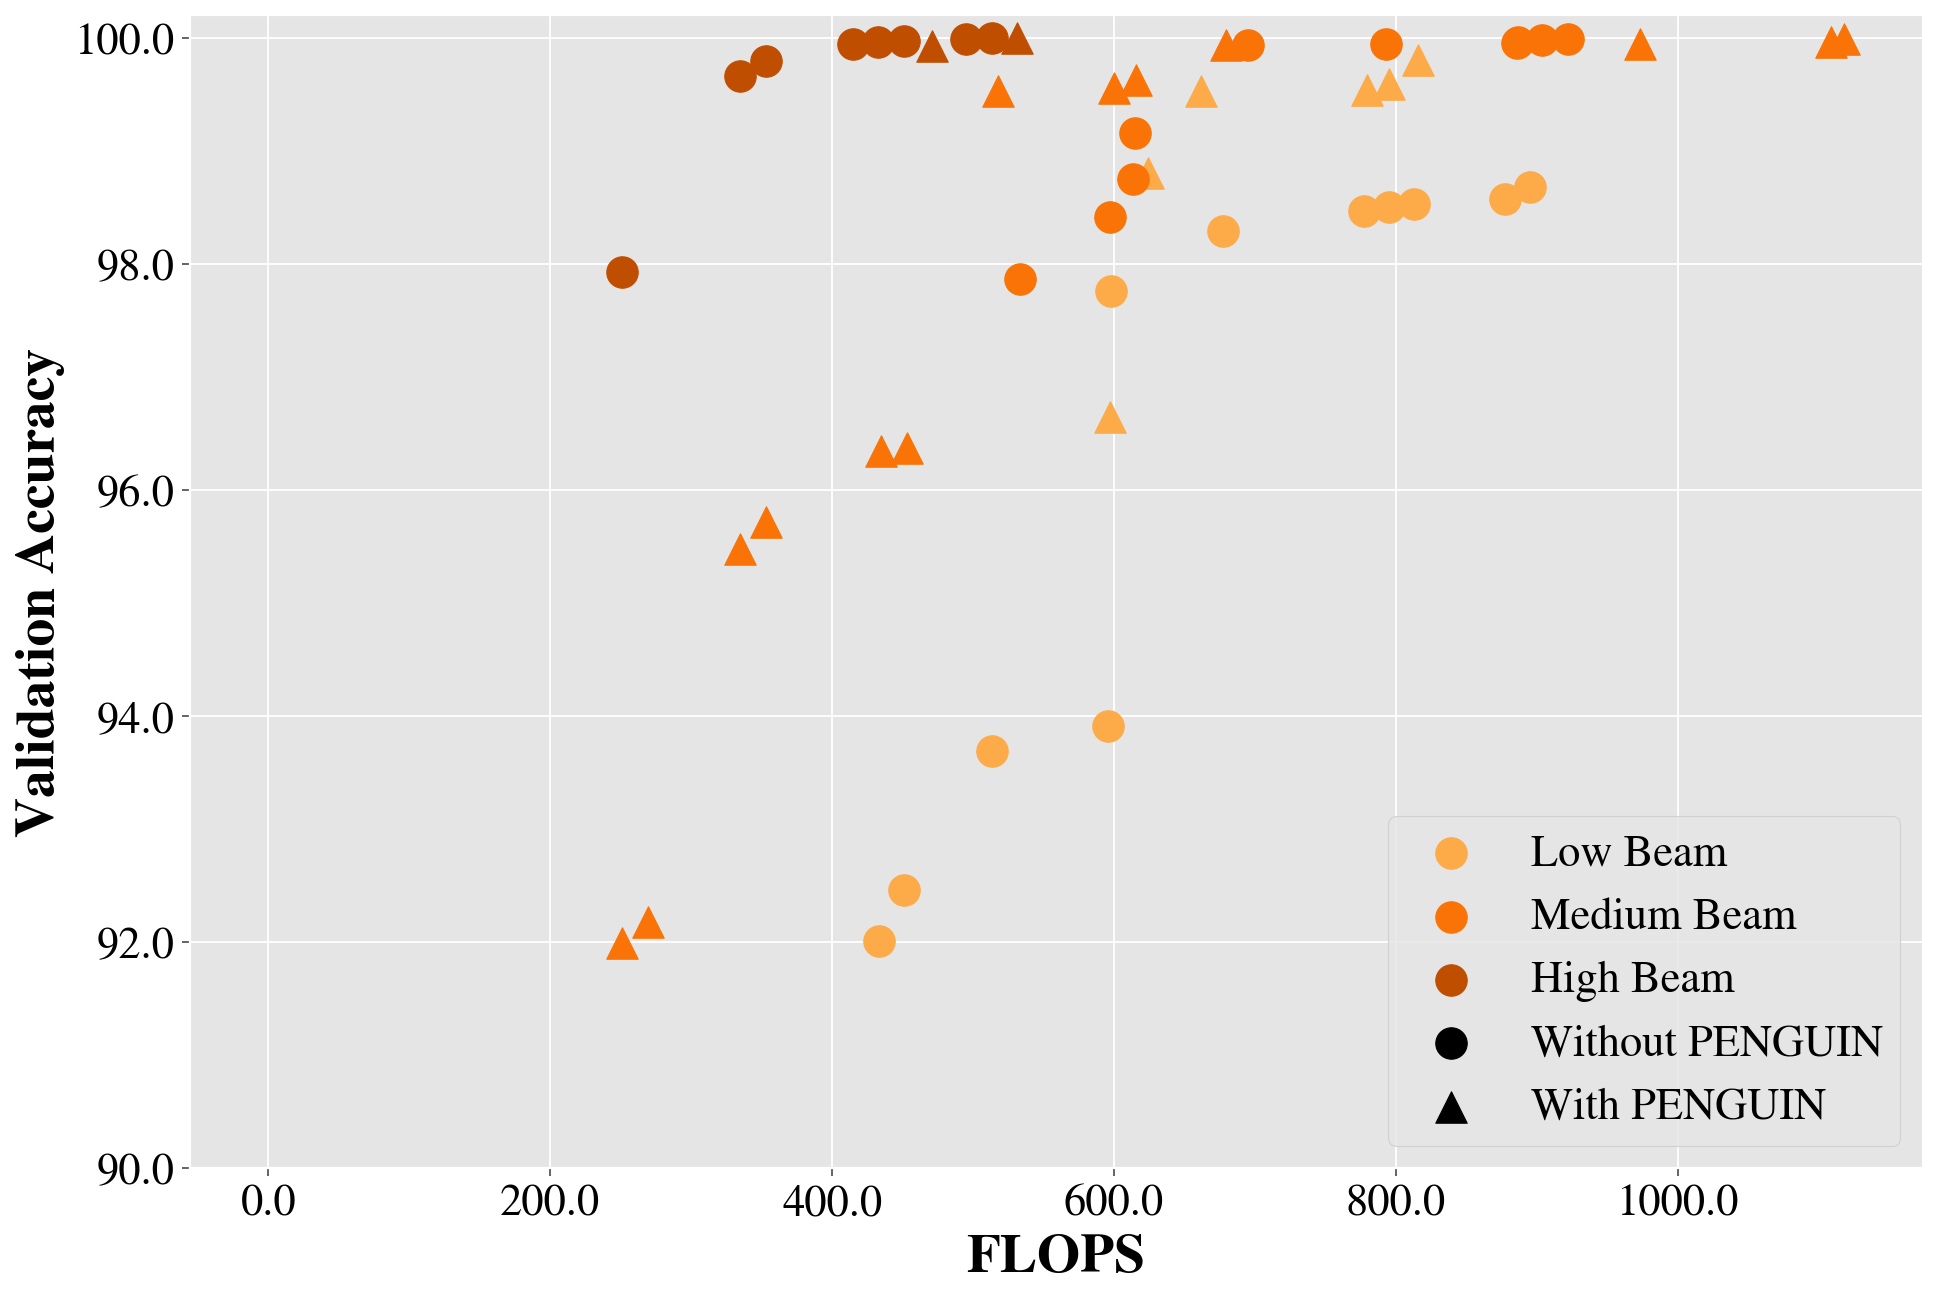

In [21]:
# 1 GPU - With and Without PENGUIN
fig, ax = plt.subplots(layout='constrained', figsize=figsize, dpi=160)

plt.xlabel('FLOPS', color='black', font=lfont)
plt.ylabel('Validation Accuracy', color='black', font=lfont)
plt.ylim(90, 100.2)

colors = ["xkcd:light orange", "xkcd:orange", "xkcd:burnt orange"]
markers = ["o", "^"]
size=200

low, medium, high = (df['beam'] == "Low"), (df['beam'] == "Medium"), (df['beam'] == "High")
gpu1, gpu4 = (df['gpus'] == 1), (df['gpus'] == 4)
no_stop, stop = (df['stop'] == False), (df['stop'] == True)

low_acc = df.loc[low & gpu1 & no_stop]['final_acc'].to_numpy()
low_flops = df.loc[low & gpu1 & no_stop]['flops'].to_numpy()

low_peng_acc = df.loc[low & gpu1 & stop]['final_acc'].to_numpy()
low_peng_flops = df.loc[low & gpu1 & stop]['flops'].to_numpy()

med_acc = df.loc[medium & gpu1 & no_stop]['final_acc'].to_numpy()
med_flops = df.loc[medium & gpu1 & no_stop]['flops'].to_numpy()

med_peng_acc = df.loc[medium & gpu1 & stop]['final_acc'].to_numpy()
med_peng_flops = df.loc[medium & gpu1 & stop]['flops'].to_numpy()

high_acc = df.loc[high & gpu1 & no_stop]['final_acc'].to_numpy()
high_flops = df.loc[high & gpu1 & no_stop]['flops'].to_numpy()

high_peng_acc = df.loc[high & gpu1 & stop]['final_acc'].to_numpy()
high_peng_flops = df.loc[high & gpu1 & stop]['flops'].to_numpy()

l1 = ax.scatter(low_flops, low_acc, marker= "o" , s=size, color=colors[0], label= "Low Beam" )
l2 = ax.scatter(low_peng_flops, low_peng_acc,  s=size, marker= "^" , color=colors[0])
l3 = ax.scatter(med_flops, med_acc, marker= "o" , s=size, color=colors[1], label= "Medium Beam" )
l4 = ax.scatter(med_peng_flops, med_peng_acc, s=size, marker= "^" , color=colors[1])
l5 = ax.scatter(high_flops, high_acc, s=size, marker= "o" , color=colors[2], label= "High Beam" )
l6 = ax.scatter(high_peng_flops, high_peng_acc, s=size, marker= "^" , color=colors[2])
l7 = ax.scatter([0], [0], s=size, marker='o', color= "black" , label= "Without PENGUIN" )
l8 = ax.scatter([0], [0], s=size, marker='^', color= "black" , label= "With PENGUIN" )

ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
ax.legend(handles=[l1, l3, l5, l7, l8], loc= "lower right" , prop=tick_font)

ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
plt.savefig('figures/gpu4_pareto.png')

### 2. 4 GPUs Pareto Optimal Architectures

/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/1006846197.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/1006846197.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/1006846197.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
/var/folders/cr/6qwltv_55nn601gfq05w5r2c0000gn/T/ipykernel_42144/1006846197.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)


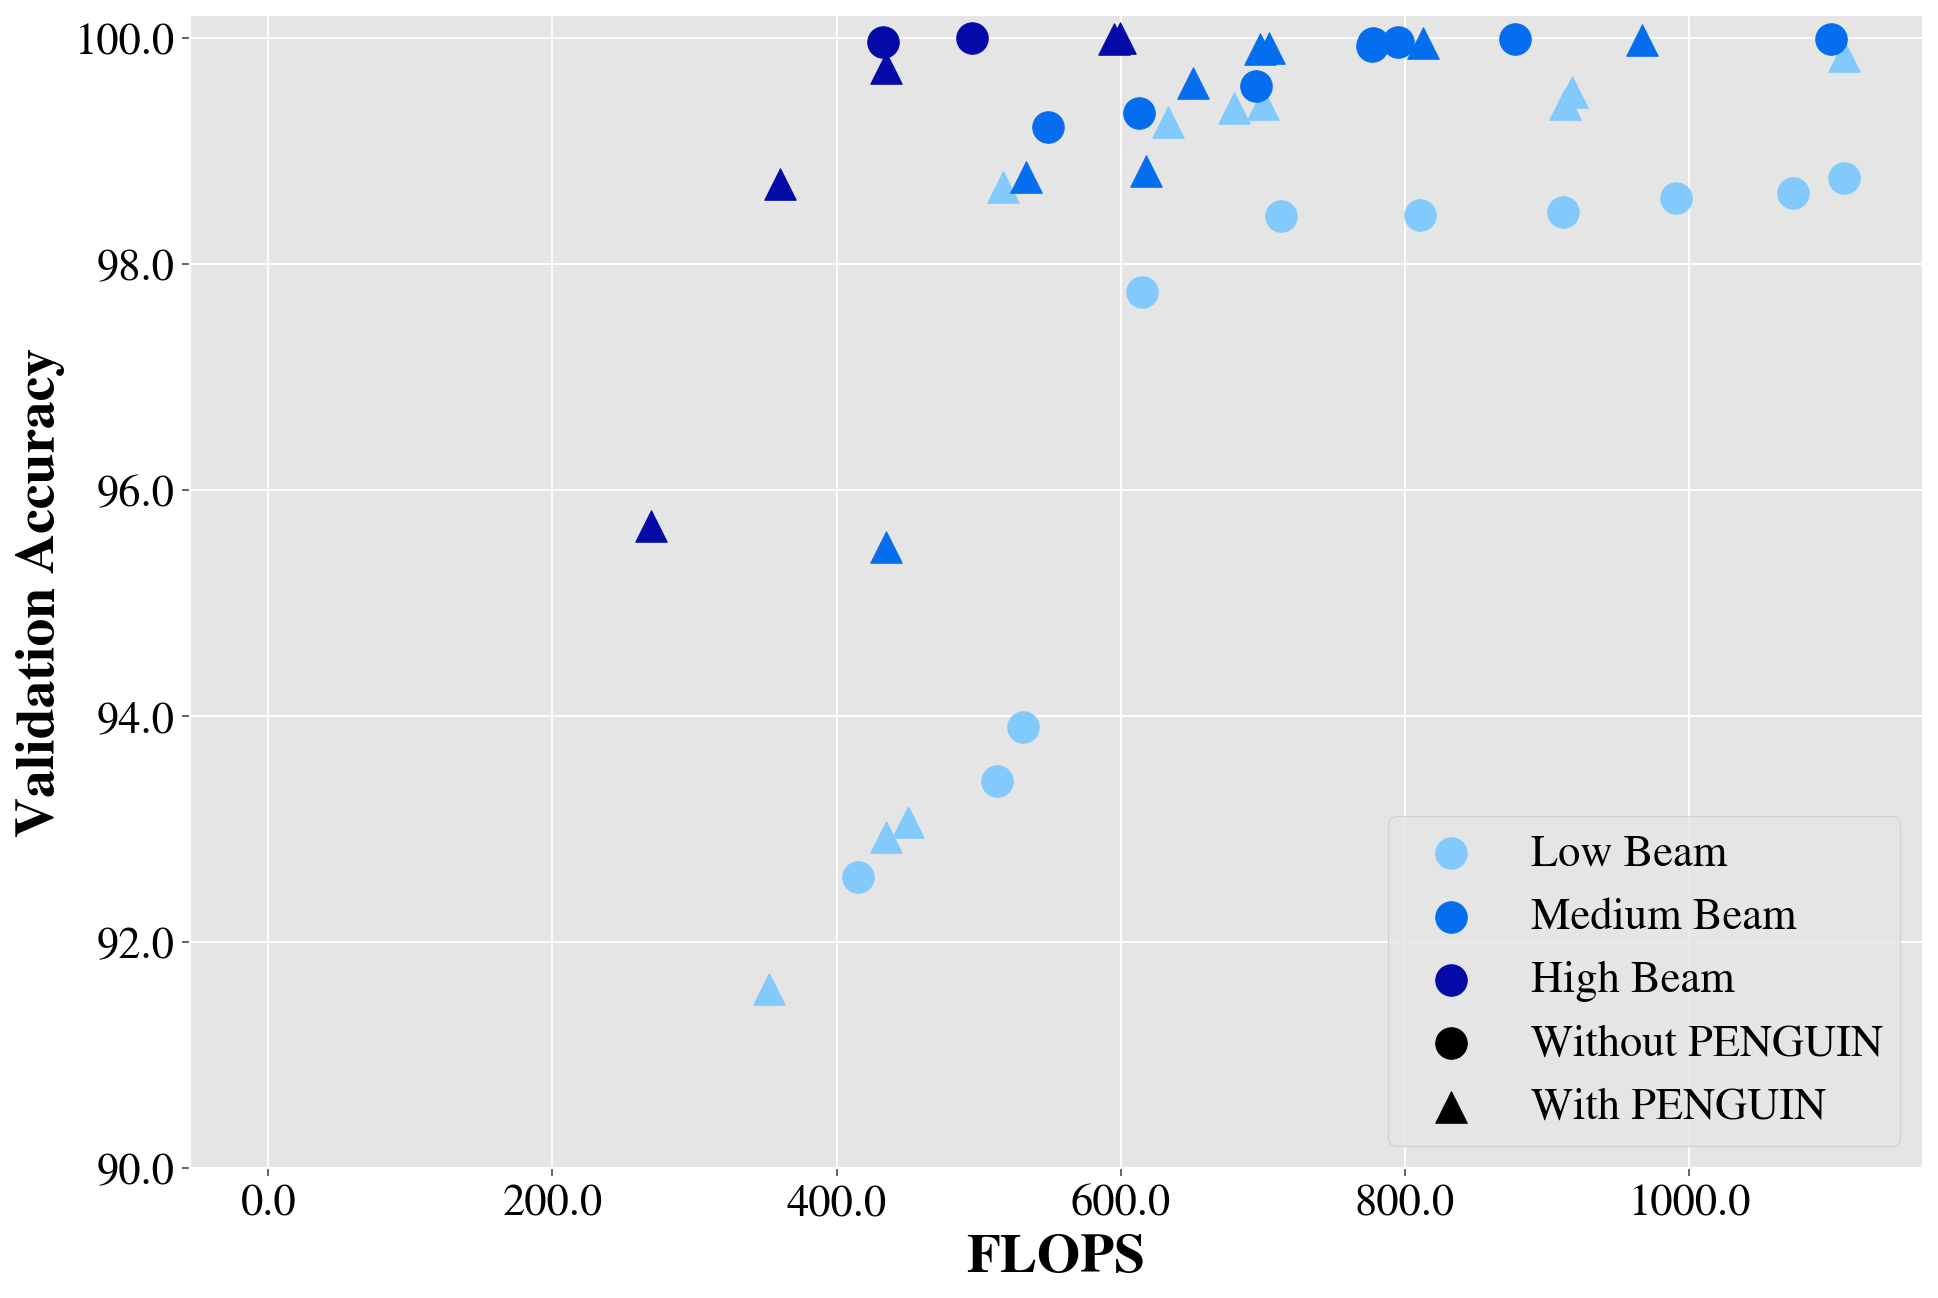

In [22]:
# 4 GPU - With and Without PENGUIN
fig, ax = plt.subplots(layout='constrained', figsize=figsize, dpi=160)

plt.xlabel('FLOPS', color='black', font=lfont)
plt.ylabel('Validation Accuracy', color='black', font=lfont)
plt.ylim(90, 100.2)

colors = ["xkcd:sky", "xkcd:cerulean blue", "xkcd:cobalt blue"]

low_acc = df.loc[low & gpu4 & no_stop]['final_acc'].to_numpy()
low_flops = df.loc[low & gpu4 & no_stop]['flops'].to_numpy()

low_peng_acc = df.loc[low & gpu4 & stop]['final_acc'].to_numpy()
low_peng_flops = df.loc[low & gpu4 & stop]['flops'].to_numpy()

med_acc = df.loc[medium & gpu4 & no_stop]['final_acc'].to_numpy()
med_flops = df.loc[medium & gpu4 & no_stop]['flops'].to_numpy()

med_peng_acc = df.loc[medium & gpu4 & stop]['final_acc'].to_numpy()
med_peng_flops = df.loc[medium & gpu4 & stop]['flops'].to_numpy()

high_acc = df.loc[high & gpu4 & no_stop]['final_acc'].to_numpy()
high_flops = df.loc[high & gpu4 & no_stop]['flops'].to_numpy()

high_peng_acc = df.loc[high & gpu4 & stop]['final_acc'].to_numpy()
high_peng_flops = df.loc[high & gpu4 & stop]['flops'].to_numpy()

l1 = ax.scatter(low_flops, low_acc, marker= "o" , s=size, color=colors[0], label= "Low Beam" )
l2 = ax.scatter(low_peng_flops, low_peng_acc,  s=size, marker= "^" , color=colors[0])
l3 = ax.scatter(med_flops, med_acc, marker= "o" , s=size, color=colors[1], label= "Medium Beam" )
l4 = ax.scatter(med_peng_flops, med_peng_acc, s=size, marker= "^" , color=colors[1])
l5 = ax.scatter(high_flops, high_acc, s=size, marker= "o" , color=colors[2], label= "High Beam" )
l6 = ax.scatter(high_peng_flops, high_peng_acc, s=size, marker= "^" , color=colors[2])
l7 = ax.scatter([0], [0], s=size, marker='o', color= "black" , label= "Without PENGUIN" )
l8 = ax.scatter([0], [0], s=size, marker='^', color= "black" , label= "With PENGUIN" )

ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
ax.legend(handles=[l1, l3, l5, l7, l8], loc= "lower right" , prop=tick_font)

ax.set_xticklabels(ax.get_xticks(), color= "black" , font=tick_font)
ax.set_yticklabels(ax.get_yticks(), color= "black" , font=tick_font)
plt.savefig('figures/gpu4_pareto.png')